In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.image as mpimg


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from snf_code import prepare_image, ImageEnergy, ImageSampler

In [5]:
img=mpimg.imread('./data/labrador.jpg')
img_density, img_energy = prepare_image(img, crop=(10, 710, 240, 940), 
                                        white_cutoff=225, gauss_sigma=3, background=0.01)
mean = [350, 350]
scale = [100, 100]
tail = 3.5

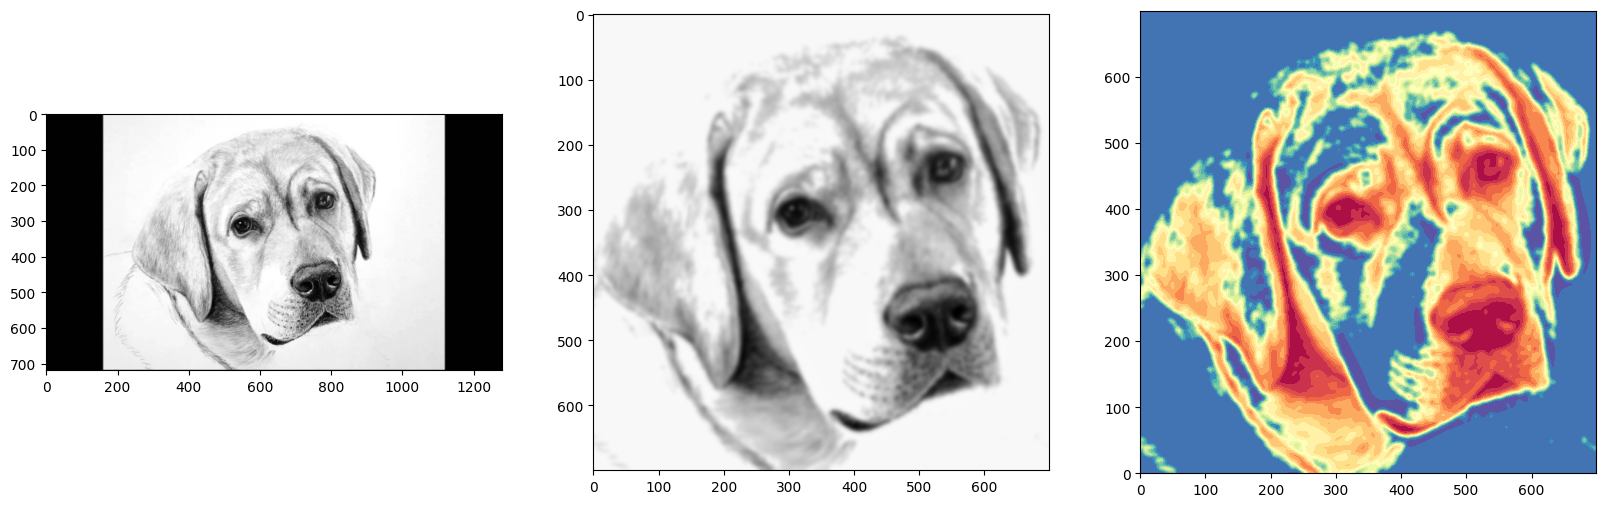

In [6]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
axes[0].imshow(img)
axes[1].imshow(img_density, vmin=0, vmax=1, cmap='gray_r')
axes[2].contourf(img_energy[::-1], 20, vmin=img_energy.min(), vmax=img_energy.max(), cmap='Spectral')

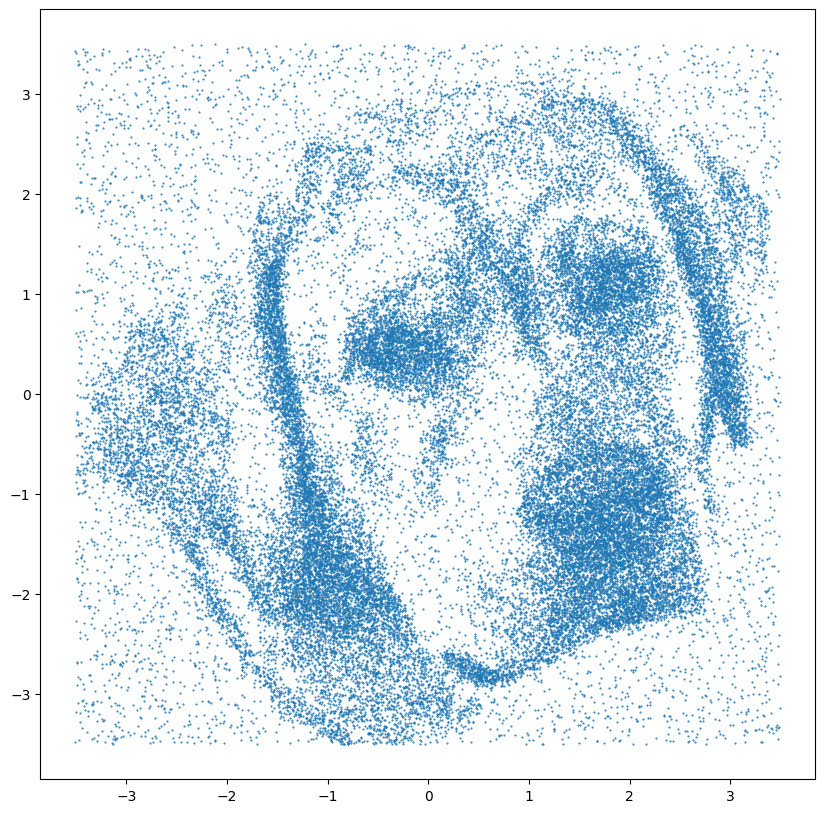

In [7]:
sampler = ImageSampler(img_density[::-1].copy(), mean=mean, scale=scale)
X = sampler.sample(50000)
data = torch.tensor(X, dtype=torch.float32)

plt.figure(figsize=(10, 10))
plt.plot(X[:, 0], X[:, 1], linewidth=0, marker='.', markersize=1)

In [8]:
ndim = X.shape[-1]

In [9]:
ndim

2

In [10]:
target = ImageEnergy(img_energy[::-1].copy(), mean=mean, scale=scale)

In [11]:
dataset = torch.Tensor(X).float().reshape((-1,ndim))
dataset = dataset.to(device)

In [12]:
torch.std(dataset, dim=-1)

tensor([2.5052, 0.8170, 0.4354,  ..., 1.4759, 2.2845, 1.8522], device='cuda:0')

In [13]:
from Flow_Perturbation.src.DDPM import calc_alphas_betas, diffusion_loss_fn, diffusion_loss_fn

In [14]:
num_steps = 1000
alphas, betas, alphas_prod, alphas_bar_sqrt, one_minus_alphas_bar_sqrt = calc_alphas_betas(num_steps=num_steps, scaling=10, beta_min=1e-5, beta_max=5e-3)

In [15]:
from Flow_Perturbation.src.common import MLP_nonorm, MLP_var
from Flow_Perturbation.src.EDM import loss_EDM
from Flow_Perturbation.src.train import train_model_DDPM
model = MLP_nonorm(ndim=ndim,hidden_size=200,hidden_layers=1,emb_size=20).to(device)
batch_size = 128
dataset = dataset.to(device)
print(dataset.shape)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
path = 'models/dog_DDPM'
model = train_model_DDPM(model, ndim, dataloader, path, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps,num_epoch=81,lr=1e-3, loss_DDPM = diffusion_loss_fn,decay_steps = 100)
print('Training done!')


torch.Size([50000, 2])
Training model...
0.7978156905649872
lr*0.5
Training done!


In [16]:
for param in model.parameters():
    param.requires_grad = False

In [17]:
from Flow_Perturbation.src.DDPM import interpolate_parameters,DDPMSamplerCoM, DDPMSampler
st, sigma_t, st_derivative, sigma_t_derivative = interpolate_parameters(num_steps, alphas_prod)
Sampler = DDPMSampler(model, st, st_derivative, sigma_t_derivative, device)

exact_dynamics_heun = Sampler.exact_dynamics_heun
heun_torch = Sampler.heun_torch
score_function_rearange = Sampler.score_function_rearange
score_function_1element = Sampler.score_function_1element

In [18]:
from Flow_Perturbation.src.utils import  generate_tsampling
time_forward = generate_tsampling(1, num_steps-1, 100, 2.0)
time_backward = time_forward[::-1]

(-3.5, 3.5)

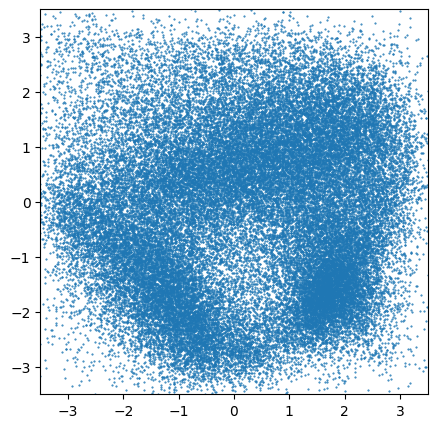

In [19]:
sampN = 50000
tmax = 1.0
epsilon = 0.01
lambdaT = tmax**2
xT = np.sqrt(lambdaT) * torch.randn((sampN, ndim)).to(device)

x0 = exact_dynamics_heun(xT, time_backward)
Y_init = x0.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_init[:, 0], Y_init[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

In [20]:
sampN = 1000
tmax = 1.0
epsilon = 0.01
lambdaT = tmax**2
xT = np.sqrt(lambdaT) * torch.randn((sampN, ndim)).to(device)

x0 = exact_dynamics_heun(xT, time_backward)
xTp = exact_dynamics_heun(x0, time_forward)

xT - xTp

tensor([[ 7.6294e-06,  1.1921e-07],
        [-9.9540e-06, -2.6226e-06],
        [ 6.7949e-06,  5.4613e-06],
        ...,
        [-8.8811e-06, -7.7486e-07],
        [-3.3259e-05, -5.3048e-06],
        [ 9.0525e-06,  8.9407e-06]], device='cuda:0')

In [21]:
energy_target = target.energy(dataset.cpu())

In [22]:
print(energy_target.mean())

tensor(1.1094)


In [23]:
sampN = 10000
lambdaT = tmax**2

xT = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps = torch.randn_like(xT)

back_coeff = 0.001
x0 = exact_dynamics_heun(xT, time_backward) + back_coeff * eps # backward dynamics

dxT = xT - exact_dynamics_heun(x0, time_forward) # this is the error in xT that needs to be matched
eps_squarenorm = torch.sum(eps**2, dim=-1)

In [24]:
from Flow_Perturbation.src.train import CustomDataset, train_model_var
from torch.utils.data import DataLoader

In [25]:
batch_size = 128
dataset = CustomDataset(x0, dxT, eps_squarenorm)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True, drop_last=True)
# Create the model
model_var = MLP_var(ndim=ndim).to(device)
model_var = train_model_var(model_var, dataloader, back_coeff, num_epoch=51,lr=1e-4,path=path,decay_steps = 500)

0 1.6909658847711024
1.6909658847711024
1 1.1753043723412049
2 0.8505070423468565
3 0.777704479602667
4 0.7522860979422544
5 0.7834146404877688
6 0.7251421786271609
7 0.7085672204311078
8 0.7025600450161176
9 0.715615669122109
10 0.6715910679254776
11 0.6793888631539468
12 0.6523758830168308
13 0.6334246565134097
14 0.6126291755682383
15 0.6492049300517791
16 0.7641624216085825
17 0.6311014267878655
18 0.6205333719650904
19 0.6155101855595907
20 0.6027888495188493
21 0.5943253074701016
22 0.6046039530864129
23 0.6148385214499938
24 0.6115688800047605
25 0.611387931001492
26 0.5985899277222462
27 0.6099007358917823
28 0.6796489300636145
29 0.5882995369342657
30 0.5978917219699957
31 0.6170828930842571
32 0.5965868486807897
33 0.6012648794895563
34 0.6083150135400968
35 0.5795346204286966
36 0.591992933780719
37 0.6072115240952908
38 0.5919789851475985
39 0.5924012099321072
40 0.5916172464688619
41 0.5644814494328622
42 0.599659093679526
43 0.5722571878861158
44 0.578193663022457
45 0.58

In [26]:
for param in model_var.parameters():
    param.requires_grad = False

In [27]:
def get_log_omega(xT, eps):
    x0 = exact_dynamics_heun(xT, time_backward) + back_coeff * eps
    # forward dynamics
    # xT = exact_dynamics_heun(tmax, 0, x0, mus0, covs0) + forw_coeff * eps_tilde
    forw_coeff = model_var(x0)
    eps_tilde = (xT - exact_dynamics_heun(x0, time_forward))/forw_coeff
    deltaSt = -0.5 * torch.sum(eps_tilde**2 - eps**2, dim=-1) - ndim * torch.log(forw_coeff).squeeze(-1) + ndim * np.log(back_coeff)
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = target.energy(x0.cpu()).reshape(-1).to(device)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [28]:
# generate starting point for the MCMC move
# we need xT_init, eps_init, log_omega_init
# do the backward-forward dynamics, get deltaSt, determine forward coeff
sampN = 50000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega(xT_init, eps_init)

In [29]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [30]:
from Flow_Perturbation.src.MC import get_vjp_score_mnoise, get_vjp_score, run_mcmc_and_save, get_jacobian_score, v_jacobian_score_batch
from Flow_Perturbation.src.utils import remove_mean, modify_samples_torch_batched_K
from Flow_Perturbation.src.utils import generate_tsampling
import os
v_jacobian_score = get_jacobian_score(score_function_1element)

In [31]:
if not os.path.exists('models/dog_DDPM/data_dog'):
    os.makedirs('models/dog_DDPM/data_dog')

In [32]:
K_x = 1
K_eps = 1

In [33]:
nmcmc =2 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega, 
                                                tmax=tmax, K_x=K_x, K_eps=K_eps, if_sava=False, if_eps=True,path='models/dog_DDPM/data_dog/dog-FP',last_steps=1,count_last=1,count_sava=1)

0 tensor(1.7311, device='cuda:0') tensor(36339, device='cuda:0')
1 tensor(1.4077, device='cuda:0') tensor(32847, device='cuda:0')


In [34]:
concatenated_x0_last_steps.shape

torch.Size([50000, 2])

(-3.5, 3.5)

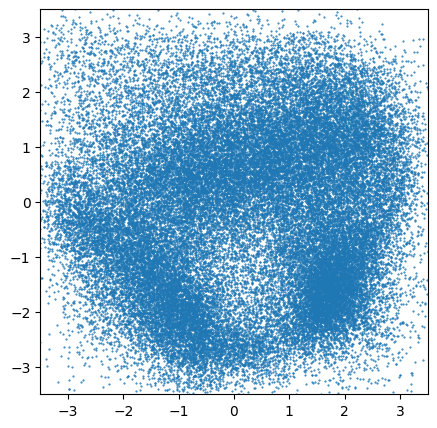

In [35]:
sampN = 50000
tmax = 1.0
epsilon = 0.01
lambdaT = tmax**2
xT = np.sqrt(lambdaT) * torch.randn((sampN, ndim)).to(device)

x0 = exact_dynamics_heun(xT, time_backward)
Y_init = x0.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_init[:, 0], Y_init[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

(-3.5, 3.5)

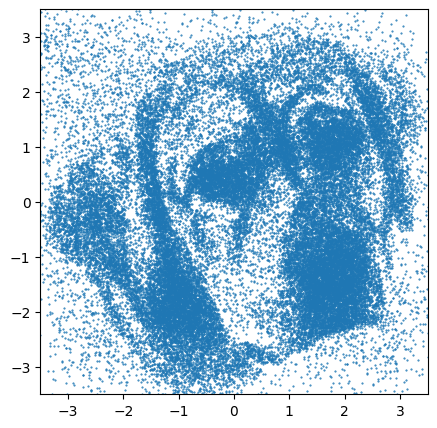

In [36]:
Y_FP = concatenated_x0_last_steps.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_FP[:, 0], Y_FP[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

In [37]:
def exact_dynamics_heun_dSt_Huch(xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = time_forward
    xt = xtn1 # set the initial x
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    
    eps = torch.randn_like(xt)
    _, div_xt = get_vjp_score(xt, ts[len(ts)-1], eps, score_function_rearange)
    #print(score_xt)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(xt, ts[i], ts[i-1])
        eps = torch.randn_like(xt_new)
        _, div_xt_new = get_vjp_score(xt_new, ts[i-1], eps, score_function_rearange)

        dSt += (ts[i]-ts[i-1])*(div_xt + div_xt_new)/2
        
        div_xt = div_xt_new
        xt = xt_new
    return xt, -dSt

 
def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt_Huch(xT) 
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = target.energy(x0.cpu()).reshape(-1).to(device)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [38]:

sampN = 50000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)
log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [39]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [40]:
nmcmc = 2 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega_J, 
                                                tmax=tmax, K_x=K_x, K_eps=K_eps,if_sava=False, if_eps=False,path='models/dog_DDPM/data_dog/dog-H1',last_steps=1,count_last=1,count_sava=1)

0 tensor(1.7567, device='cuda:0') tensor(37141, device='cuda:0')
1 tensor(1.3224, device='cuda:0') tensor(33932, device='cuda:0')


(-3.5, 3.5)

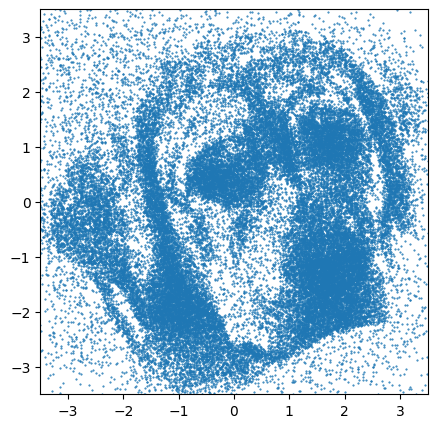

In [41]:
Y_H1 = concatenated_x0_last_steps.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_H1[:, 0], Y_H1[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

In [42]:
def exact_dynamics_heun_dSt_Huch(xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = time_forward
    xt = xtn1 # set the initial x
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    nnoise = 10 # we want to average over 10 noises
    eps = torch.randn((nnoise, xt.shape[0], xt.shape[1])).to(device)
    _, div_xt = get_vjp_score_mnoise(xt, ts[len(ts)-1], eps, score_function_rearange)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(xt, ts[i], ts[i-1])

        eps = torch.randn((nnoise, xt.shape[0], xt.shape[1])).to(device)
        _, div_xt_new = get_vjp_score_mnoise(xt_new, ts[i-1], eps, score_function_rearange)

        dSt += (ts[i]-ts[i-1])*(div_xt + div_xt_new)/2
        
        div_xt = div_xt_new
        xt = xt_new
    return xt, -dSt

def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt_Huch(xT) 
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = target.energy(x0.cpu()).reshape(-1).to(device)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [43]:
sampN = 50000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [44]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [45]:
nmcmc =2 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega_J, 
                                                    tmax=tmax, K_x=K_x, K_eps=K_eps, if_sava=False, if_eps=False,path='models/dog_DDPM/data_dog/dog-H10',last_steps=1,count_last=1,count_sava=1)

0 tensor(1.8063, device='cuda:0') tensor(37620, device='cuda:0')
1 tensor(1.3847, device='cuda:0') tensor(34349, device='cuda:0')


(-3.5, 3.5)

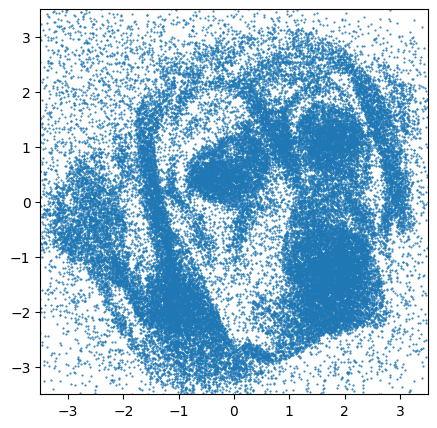

In [46]:
Y_H10 = concatenated_x0_last_steps.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_H10[:, 0], Y_H10[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)


In [47]:
def exact_dynamics_heun_dSt(xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = time_forward
    xt = xtn1 # set the initial x
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    
    jj_score_xt = v_jacobian_score_batch(xt, ts[len(ts)-1], v_jacobian_score,batch_size=5000)
    div_xt = torch.einsum("...ii", jj_score_xt)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(xt, ts[i], ts[i-1])
        jj_score_xt_new = v_jacobian_score_batch(xt_new, ts[i-1], v_jacobian_score,batch_size=5000)
        div_xt_new = torch.einsum("...ii", jj_score_xt_new)
        dSt += (ts[i]-ts[i-1])*(div_xt + div_xt_new)/2
        #print((ts[i]-ts[i-1]))
        div_xt = div_xt_new
        xt = xt_new
        del xt_new,jj_score_xt_new,div_xt_new
    return xt, -dSt
 
def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt(xT) 
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = target.energy(x0.cpu()).reshape(-1).to(device)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [48]:

sampN = 50000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [49]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [50]:
nmcmc =2 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega_J, 
                                                tmax=tmax, K_x=K_x, K_eps=K_eps, if_sava=False, if_eps=False,path='models/dog_DDPM/data_dog/dog-J',last_steps=1,count_last=1,count_sava=1)

0 tensor(1.6938, device='cuda:0') tensor(37500, device='cuda:0')
1 tensor(1.3027, device='cuda:0') tensor(34438, device='cuda:0')


(-3.5, 3.5)

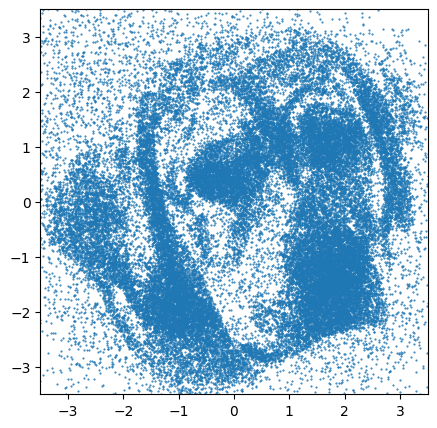

In [51]:
Y_J = concatenated_x0_last_steps.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_J[:, 0], Y_J[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

(-3.5, 3.5)

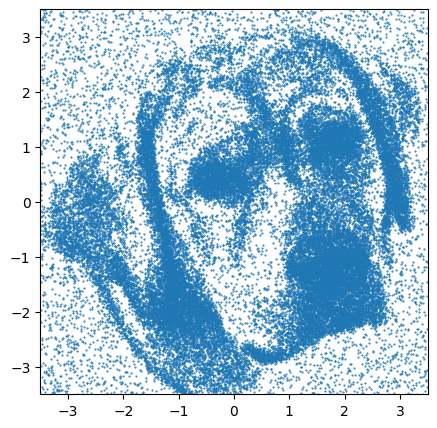

In [52]:
sampler = ImageSampler(img_density[::-1].copy(), mean=mean, scale=scale)
X = sampler.sample(50000)
data = torch.tensor(X, dtype=torch.float32)

Y_RNVP = data.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_RNVP[:, 0], Y_RNVP[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

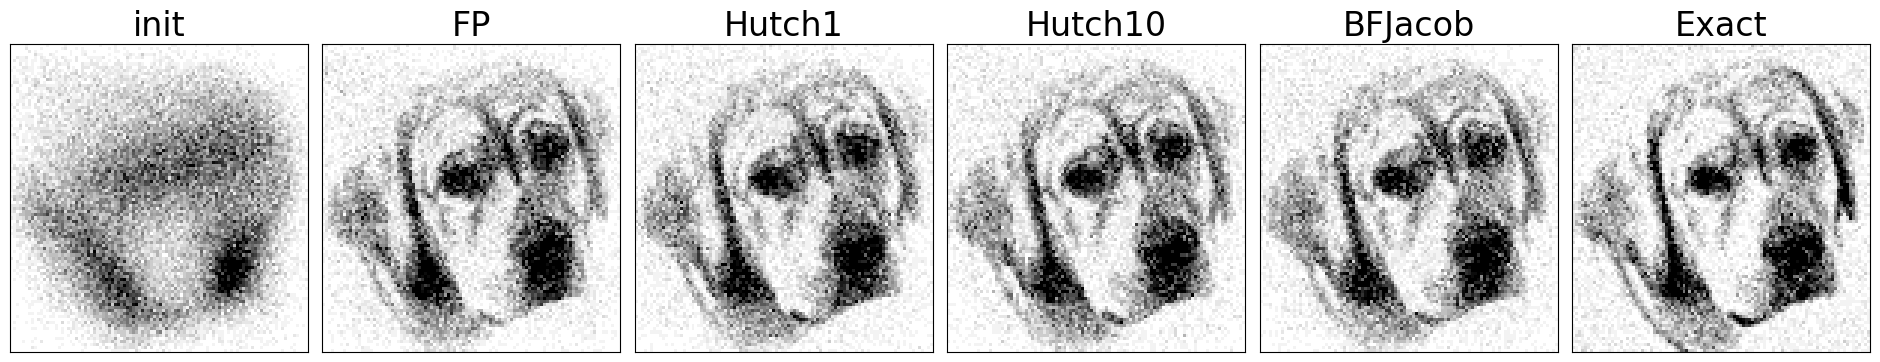

In [53]:
nbins = 100
vmax = 20
xrange=(-3.5, 3.5)
yrange=(-3.5, 3.5)

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(24, 4))
fig.subplots_adjust(wspace=0.05)

axes[0].set_title('init', fontsize=24)
axes[1].set_title('FP', fontsize=24)
axes[2].set_title('Hutch1', fontsize=24)
axes[3].set_title('Hutch10', fontsize=24)
axes[4].set_title('BFJacob', fontsize=24)
axes[5].set_title('Exact', fontsize=24)
axes[0].hist2d(Y_init.numpy()[:, 0], Y_init.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[1].hist2d(Y_FP.numpy()[:, 0], Y_FP.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[2].hist2d(Y_H1.numpy()[:, 0], Y_H1.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[3].hist2d(Y_H10.numpy()[:, 0], Y_H10.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[4].hist2d(Y_J.numpy()[:, 0], Y_J.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[5].hist2d(X[:, 0], X[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
for i in range(6):
    axes[i].set_xlim(xrange[0], xrange[1])
    axes[i].set_ylim(yrange[0], yrange[1])
    axes[i].set_xticks([])
    axes[i].set_yticks([])